# Premier League Match Analysis: A Statistical Exploration

This project analyzes Premier League match results from the 2006-2007 season to the 2023-2024 season. It serves as a portfolio piece to demonstrate a wide array of foundational data analysis skills, from basic statistical concepts to more advanced techniques.

First, we need to import the libraries that we're going to use for analysis.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Next, we will go ahead and import the data from our csv file into a Pandas DataFrame

In [2]:
results_df = pd.read_csv("data/results_data.csv")

Now that the data is loaded into a DataFrame we can just take a quick look at what we might be working with. First, we will have Python display some of the basic _info_ of the DataFrame and then we will actually look at the _first 5 rows_ of the DataFrame

In [3]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   home_team   6500 non-null   object
 1   away_team   6500 non-null   object
 2   home_goals  6500 non-null   int64 
 3   away_goals  6500 non-null   int64 
 4   season      6500 non-null   object
dtypes: int64(2), object(3)
memory usage: 254.0+ KB


In [4]:
results_df.head()

,home_team,away_team,home_goals,away_goals,season
0,Sheffield United,Liverpool,1,1,2006-2007
1,Arsenal,Aston Villa,1,1,2006-2007
2,Everton,Watford,2,1,2006-2007
3,Newcastle United,Wigan Athletic,2,1,2006-2007
4,Portsmouth,Blackburn Rovers,3,0,2006-2007


The dataset appears fine. I am a little suspicious of the team names and whether or not they are all spelled correctly. Let's take a look at the unique values that we have for the columns *home_team* *away_team* and *season*.

In [5]:
sorted(results_df.home_team.unique())

['AFC Bournemouth',
 'Arsenal',
 'Aston Villa',
 'Birmingham City',
 'Blackburn Rovers',
 'Blackpool',
 'Bolton Wanderers',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Brighton & Hove Albion',
 'Brighton and Hove Albion',
 'Burnley',
 'Cardiff',
 'Cardiff City',
 'Charlton Athletic',
 'Chelsea',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Huddersfield Town',
 'Hull City',
 'Leeds',
 'Leicester',
 'Leicester City',
 'Liverpool',
 'Luton Town',
 'Man City',
 'Man United',
 'Manchester City',
 'Manchester United',
 'Middlesbrough',
 'Newcastle',
 'Newcastle United',
 'Norwich',
 'Norwich City',
 'Nottingham',
 'Nottingham Forest',
 'Portsmouth',
 'Queens Park Rangers',
 'Reading',
 'Sheffield United',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Tottenham',
 'Tottenham Hotspur',
 'Watford',
 'West Brom',
 'West Bromwich Albion',
 'West Ham',
 'West Ham United',
 'Wigan Athletic',
 'Wolverhampton Wanderers',
 'Wolves']

As I suspected we can already see that our names are going to have issues. For example, in the home_team column we have 3 different versions of the team Brighton & Hove Albion. Let's go ahead and make a list of all the team names from both columns, sort it, and use that list to create a name map for both columns.

In [6]:
team_list = []

for team in results_df.home_team.unique():
    team_list.append(team)

for team in results_df.away_team.unique():
    if team not in team_list:
        team_list.append(team)

team_list.sort()

team_list_length = len(team_list)

print(f"The number of unique team names in this list is: {team_list_length}")

for team in team_list:
    print(team)

The number of unique team names in this list is: 58
AFC Bournemouth
Arsenal
Aston Villa
Birmingham City
Blackburn Rovers
Blackpool
Bolton Wanderers
Bournemouth
Brentford
Brighton
Brighton & Hove Albion
Brighton and Hove Albion
Burnley
Cardiff
Cardiff City
Charlton Athletic
Chelsea
Crystal Palace
Derby County
Everton
Fulham
Huddersfield
Huddersfield Town
Hull City
Leeds
Leicester
Leicester City
Liverpool
Luton Town
Man City
Man United
Manchester City
Manchester United
Middlesbrough
Newcastle
Newcastle United
Norwich
Norwich City
Nottingham
Nottingham Forest
Portsmouth
Queens Park Rangers
Reading
Sheffield United
Southampton
Stoke City
Sunderland
Swansea City
Tottenham
Tottenham Hotspur
Watford
West Brom
West Bromwich Albion
West Ham
West Ham United
Wigan Athletic
Wolverhampton Wanderers
Wolves


I am going to create a dictionary to map all of the variations to standard names. We will simply pick 1 version of a team name and apply it to any variations that might occur in the list.

In [7]:
team_name_mapping = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton": "Brighton and Hove Albion",
    "Brighton & Hove Albion": "Brighton and Hove Albion",
    "Cardiff": "Cardiff City",
    "Huddersfield": "Huddersfield Town",
    "Leicester": "Leicester City",
    "Man City": "Manchester City",
    "Man United": "Manchester United",
    "Newcastle": "Newcastle United",
    "Norwich": "Norwich City",
    "Nottingham": "Nottingham Forest",
    "Tottenham": "Tottenham Hotspur",
    "West Brom": "West Bromwich Albion",
    "West Ham": "West Ham United",
    "Wolves": "Wolverhampton Wanderers"
}

Let's go ahead and apply our mapping and just double check that we captured all of the issues in our columns.

In [8]:
results_df.home_team = results_df.home_team.replace(team_name_mapping)
results_df.away_team = results_df.away_team.replace(team_name_mapping)

In [9]:
team_list = []

for team in results_df.home_team.unique():
    team_list.append(team)

for team in results_df.away_team.unique():
    if team not in team_list:
        team_list.append(team)

team_list.sort()

team_list_length = len(team_list)

print(f"The number of unique team names in this list is: {team_list_length}")

for team in team_list:
    print(team)

The number of unique team names in this list is: 43
Arsenal
Aston Villa
Birmingham City
Blackburn Rovers
Blackpool
Bolton Wanderers
Bournemouth
Brentford
Brighton and Hove Albion
Burnley
Cardiff City
Charlton Athletic
Chelsea
Crystal Palace
Derby County
Everton
Fulham
Huddersfield Town
Hull City
Leeds
Leicester City
Liverpool
Luton Town
Manchester City
Manchester United
Middlesbrough
Newcastle United
Norwich City
Nottingham Forest
Portsmouth
Queens Park Rangers
Reading
Sheffield United
Southampton
Stoke City
Sunderland
Swansea City
Tottenham Hotspur
Watford
West Bromwich Albion
West Ham United
Wigan Athletic
Wolverhampton Wanderers


I think we have taken care of all of the issues with the team names. Lets just take a look at our *season* column and the unique values for that variable.

In [10]:
print(results_df.season.unique())

['2006-2007' '2007-2008' '2008-2009' '2009-2010' '2010-2011' '2011-2012'
 '2012-2013' '2013-2014' '2014-2015' '2015-2016' '2016-2017' '2017-2018'
 '2018-2019' '2019-2020' '2020-2021' '2021-2022' '2022-2023' '2023-2024']


Since we have already shown in a previous step that we have no null values and soccer matches are allowed to have 0 goals scored I will not check the home_goals and away_goals columns. This is for 2 reasons. One, if the data has no values that are specifically labled null or left blank, and a team is allowed to score 0 goals in a game, we cannot assume that a 0 means that the data is missing or null. Two, we will be later looking at the distribution of this data and getting an idea for it's shape and potential outliers. So we can leave these alone for now.

Next, let's just make sure that the DataFrame data types are exactly how we want them to be for analysis. Let's go ahead and change the *home_team*, *away_team*, and *season* to the categorical data type.

In [11]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   home_team   6500 non-null   object
 1   away_team   6500 non-null   object
 2   home_goals  6500 non-null   int64 
 3   away_goals  6500 non-null   int64 
 4   season      6500 non-null   object
dtypes: int64(2), object(3)
memory usage: 254.0+ KB


In [12]:
results_df.home_team = results_df.home_team.astype('category')
results_df.away_team = results_df.away_team.astype('category')
results_df.season = results_df.season.astype('category')

In [13]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   home_team   6500 non-null   category
 1   away_team   6500 non-null   category
 2   home_goals  6500 non-null   int64   
 3   away_goals  6500 non-null   int64   
 4   season      6500 non-null   category
dtypes: category(3), int64(2)
memory usage: 124.2 KB


## Feature Engineering

Before we begin to do further analysis I want to create a couple more variables that we might want to keep track of. I am going to start with some basic additions and then work up to some more complex ones.

Let's start with a goal difference column and a total goals column.

In [14]:
results_df["goal_difference"] = results_df.home_goals - results_df.away_goals
results_df["total_goals"] = results_df.home_goals + results_df.away_goals
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals
0,Sheffield United,Liverpool,1,1,2006-2007,0,2
1,Arsenal,Aston Villa,1,1,2006-2007,0,2
2,Everton,Watford,2,1,2006-2007,1,3
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3


I am going to also create a column for the result of the match. I'm going to create it as a categorical variable at first and then use Python's one-hot-encoding to break it down into binary columns.

In [15]:
results_df["result"] = results_df.goal_difference.apply(lambda x: "home_win" if x > 0 else ("draw" if x == 0 else "away_win"))
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,draw
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,draw
2,Everton,Watford,2,1,2006-2007,1,3,home_win
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,home_win
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,home_win


I'm going to go ahead and turn the new *result* column into three binary columns by using Panda's get_dummies.

In [16]:
results_df = pd.get_dummies(data=results_df,columns=["result"])
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,False,True,False
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,False,True,False
2,Everton,Watford,2,1,2006-2007,1,3,False,False,True
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,False,False,True
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,False,False,True


I want to create a column that shows the team's average goals scored for the season up to that point. I also want to show their total goals scored. I'm going to create a function that will help me do this.

In [17]:
def calculate_average_goals_seasonal(df):
    df["home_team_goals_scored"] = 0
    df["away_team_goals_scored"] = 0
    df["home_team_avg_goals_scored"] = 0.0
    df["away_team_avg_goals_scored"] = 0.0
    counter = 1

    for season in df['season'].unique():
        temp_season_df = df[df['season'] == season]
        for index in range(len(temp_season_df)):
            home_team = temp_season_df.iloc[index, 0]
            away_team = temp_season_df.iloc[index, 1]
            temp_df = temp_season_df.iloc[:index].reset_index(drop=True)

            home_team_home_goals_table = temp_df[temp_df.home_team == home_team]
            home_team_away_goals_table = temp_df[temp_df.away_team == home_team]
            home_team_home_goals_total = home_team_home_goals_table.home_goals.sum()
            home_team_away_goals_total = home_team_away_goals_table.away_goals.sum()
            home_team_cumulative_total = home_team_home_goals_total + home_team_away_goals_total
            home_team_games_count = len(home_team_home_goals_table) + len(home_team_away_goals_table)
            home_team_cumulative_average = home_team_cumulative_total / home_team_games_count if home_team_games_count > 0 else 0
            home_team_cumulative_average = round(home_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'home_team_avg_goals_scored'] = home_team_cumulative_average
            df.at[temp_season_df.index[index], 'home_team_goals_scored'] = home_team_cumulative_total

            away_team_home_goals_table = temp_df[temp_df.home_team == away_team]
            away_team_away_goals_table = temp_df[temp_df.away_team == away_team]
            away_team_home_goals_total = away_team_home_goals_table.home_goals.sum()
            away_team_away_goals_total = away_team_away_goals_table.away_goals.sum()
            away_team_cumulative_total = away_team_home_goals_total + away_team_away_goals_total
            away_team_games_count = len(away_team_home_goals_table) + len(away_team_away_goals_table)
            away_team_cumulative_average = away_team_cumulative_total / away_team_games_count if away_team_games_count > 0 else 0
            away_team_cumulative_average = round(away_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'away_team_avg_goals_scored'] = away_team_cumulative_average
            df.at[temp_season_df.index[index], 'away_team_goals_scored'] = away_team_cumulative_total
    return df

In [18]:
results_df = calculate_average_goals_seasonal(results_df)

Let's go ahead and take a look at the DataFrame info followed by a look at the top 10 rows.

In [19]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   home_team                   6500 non-null   category
 1   away_team                   6500 non-null   category
 2   home_goals                  6500 non-null   int64   
 3   away_goals                  6500 non-null   int64   
 4   season                      6500 non-null   category
 5   goal_difference             6500 non-null   int64   
 6   total_goals                 6500 non-null   int64   
 7   result_away_win             6500 non-null   bool    
 8   result_draw                 6500 non-null   bool    
 9   result_home_win             6500 non-null   bool    
 10  home_team_goals_scored      6500 non-null   int64   
 11  away_team_goals_scored      6500 non-null   int64   
 12  home_team_avg_goals_scored  6500 non-null   float64 
 13  away_team_avg_goal

In [20]:
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,False,True,False,0,0,0.0,0.0
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,False,True,False,0,0,0.0,0.0
2,Everton,Watford,2,1,2006-2007,1,3,False,False,True,0,0,0.0,0.0
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,False,False,True,0,0,0.0,0.0
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,False,False,True,0,0,0.0,0.0


I think that I would like to create one more feature that will give us the team's total goals conceded and the average goals conceded. This will give us some kind of metric to measure a team's defense.

In [21]:
def calculate_conceded_goals_seasonal(df):
    df["home_team_goals_conceded"] = 0
    df["away_team_goals_conceded"] = 0
    df["home_team_avg_goals_conceded"] = 0.0
    df["away_team_avg_goals_conceded"] = 0.0
    counter = 1

    for season in df['season'].unique():
        temp_season_df = df[df['season'] == season]
        for index in range(len(temp_season_df)):
            home_team = temp_season_df.iloc[index, 0]
            away_team = temp_season_df.iloc[index, 1]
            temp_df = temp_season_df.iloc[:index].reset_index(drop=True)

            home_team_home_goals_conceded_table = temp_df[temp_df.home_team == home_team]
            home_team_away_conceded_table = temp_df[temp_df.away_team == home_team]
            home_team_home_goals_conceded_total = home_team_home_goals_conceded_table.away_goals.sum()
            home_team_away_goals_conceded_total = home_team_away_conceded_table.home_goals.sum()
            home_team_cumulative_total = home_team_home_goals_conceded_total + home_team_away_goals_conceded_total
            home_team_games_count = len(home_team_home_goals_conceded_table) + len(home_team_away_conceded_table)
            home_team_cumulative_average = home_team_cumulative_total / home_team_games_count if home_team_games_count > 0 else 0
            home_team_cumulative_average = round(home_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'home_team_avg_goals_conceded'] = home_team_cumulative_average
            df.at[temp_season_df.index[index], 'home_team_goals_conceded'] = home_team_cumulative_total

            away_team_home_goals_conceded_table = temp_df[temp_df.home_team == away_team]
            away_team_away_goals_conceded_table = temp_df[temp_df.away_team == away_team]
            away_team_home_goals_conceded_total = away_team_home_goals_conceded_table.away_goals.sum()
            away_team_away_goals_conceded_total = away_team_away_goals_conceded_table.home_goals.sum()
            away_team_cumulative_total = away_team_home_goals_conceded_total + away_team_away_goals_conceded_total
            away_team_games_count = len(away_team_home_goals_conceded_table) + len(away_team_away_goals_conceded_table)
            away_team_cumulative_average = away_team_cumulative_total / away_team_games_count if away_team_games_count > 0 else 0
            away_team_cumulative_average = round(away_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'away_team_avg_goals_conceded'] = away_team_cumulative_average
            df.at[temp_season_df.index[index], 'away_team_goals_conceded'] = away_team_cumulative_total
    return df

results_df = calculate_conceded_goals_seasonal(results_df)

results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_goals_conceded,away_team_goals_conceded,home_team_avg_goals_conceded,away_team_avg_goals_conceded
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,False,True,False,0,0,0.0,0.0,0,0,0.0,0.0
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,False,True,False,0,0,0.0,0.0,0,0,0.0,0.0
2,Everton,Watford,2,1,2006-2007,1,3,False,False,True,0,0,0.0,0.0,0,0,0.0,0.0
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,False,False,True,0,0,0.0,0.0,0,0,0.0,0.0
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,False,False,True,0,0,0.0,0.0,0,0,0.0,0.0


## Exploratory Data Analysis

Now that we have created quite a few features for our data and we have cleaned it up we can move on to some EDA. We just want to get a feel for the data.

In [22]:
results_df.describe(include='all')

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_goals_conceded,away_team_goals_conceded,home_team_avg_goals_conceded,away_team_avg_goals_conceded
count,6500,6500,6500.000000,6500.000000,6500,6500.000000,6500.000000,6500,6500,6500,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
unique,43,43,NaN,NaN,18,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Arsenal,Tottenham Hotspur,NaN,NaN,2006-2007,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,326,327,NaN,NaN,380,NaN,NaN,4562,4896,3542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.547692,1.197692,NaN,0.350000,2.745385,NaN,NaN,NaN,24.518308,24.656769,1.322008,1.341191,24.663385,24.469231,1.339414,1.322252
std,NaN,NaN,1.322699,1.170952,NaN,1.847417,1.681777,NaN,NaN,NaN,17.824186,17.772178,0.612189,0.627464,16.865750,16.824835,0.550801,0.535450
min,NaN,NaN,0.000000,0.000000,NaN,-9.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,1.000000,0.000000,NaN,-1.000000,2.000000,NaN,NaN,NaN,10.000000,10.000000,0.970000,1.000000,11.000000,11.000000,1.000000,1.000000
50%,NaN,NaN,1.000000,1.000000,NaN,0.000000,3.000000,NaN,NaN,NaN,22.000000,22.000000,1.220000,1.250000,23.000000,22.000000,1.330000,1.330000
75%,NaN,NaN,2.000000,2.000000,NaN,1.000000,4.000000,NaN,NaN,NaN,35.000000,36.000000,1.670000,1.680000,36.000000,36.000000,1.670000,1.640000


Let's go ahead and create a heatmap that can show us the correlation matrix for our numerical variables. This can give us a hint at which variables are most related to one another.

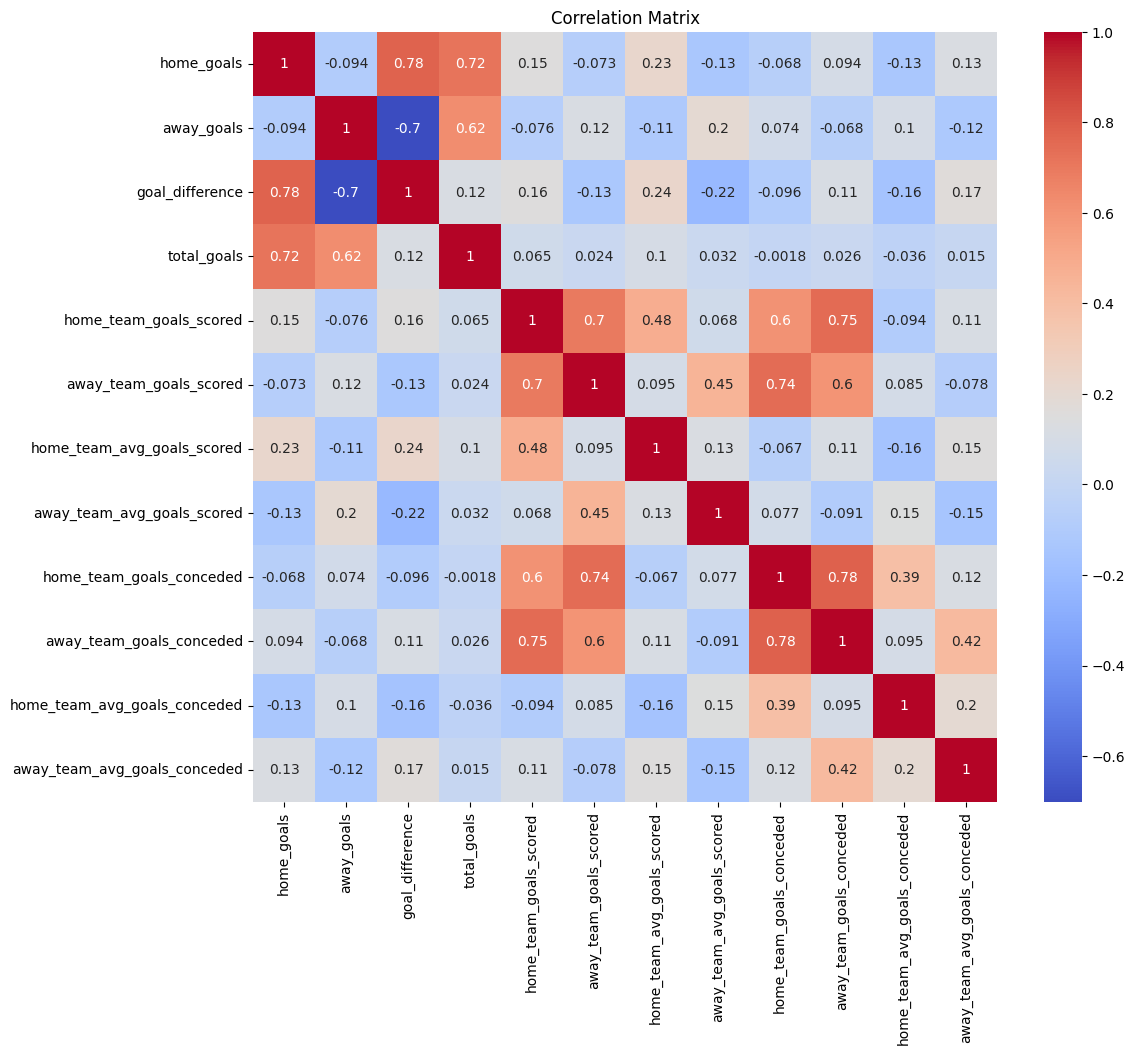

In [24]:
correlation_matrix = results_df[['home_goals', 'away_goals', 'goal_difference', 'total_goals', 'home_team_goals_scored',
                                 'away_team_goals_scored', 'home_team_avg_goals_scored', 'away_team_avg_goals_scored',
                                 'home_team_goals_conceded', 'away_team_goals_conceded', 'home_team_avg_goals_conceded', 'away_team_avg_goals_conceded']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()